In [1]:
from dash import Dash, html, dcc, callback, Output, Input
from dash_bootstrap_templates import load_figure_template
from dash import dash_table
import dash_bootstrap_components as dbc
import plotly_express as px
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
# Ladda in datasetet
athletes_events = pd.read_csv("../Uppgifter/Filer/athlete_events.csv")
medals = athletes_events.groupby(["NOC", "Medal", "Sport"], as_index=False).size().rename(columns={"size": "Medal_count"})

japan_data = athletes_events[athletes_events['NOC'] == 'JPN']

japan_medals = japan_data[japan_data['Medal'].isin(['Gold', 'Silver', 'Bronze'])]
japan_medals

most_medals = japan_medals.groupby("Sport")["Medal"].count().reset_index()
most_medals_sport = most_medals.loc[most_medals["Medal"].idxmax(), "Sport"]

top_5_sports = most_medals.sort_values(by="Medal", ascending=False).head(5)

athlete_ages = japan_data.groupby("Age")[["Sex", "Medal"]].count().reset_index()
athlete_ages = athlete_ages.rename(columns={"Sex": "Number_of_people", "Medal": "Number_of_medals"})

# Grupperar efter OS och räknar antalet medaljer
medals_per_year = japan_medals.groupby("Games")["Medal"].count().reset_index()

sns.set(style="darkgrid")

load_figure_template("darkly")

# Initiera dash, välj tema/utseende
app = Dash(
    __name__, 
    external_stylesheets=[dbc.themes.DARKLY],
    meta_tags=[{"name": "viewport", "content": "width=device-width, initial-scale=1"}]
)

# App-layout, titel och graf för japans top 5 sporter
app.layout = dbc.Container([
    dbc.Row([
    dbc.Col([
        #dbc.Col(html.Img(src=app.get_asset_url('C:\Users\user\Documents\GitHub\Japan_OS\Japan-OS\Uppgifter\Filer\japan_ålder_graf.jpg')), width={'size': 6, 'offset': 3}),
        html.H1("Japans OS-Historia: Första till Senaste", className='text-center text-primary mx-3'),
        html.Br(),
        dcc.Graph(
            id="medals_sport_graph",
            figure=px.bar(
                medals_per_year,
                x="Games",
                y="Medal",
                color="Games",
                title="Antal medaljer OS, Japan"
            )
        ),
        dcc.Graph(
            id="top_sports_graph",
            figure=px.bar(
                top_5_sports,
                x="Sport",
                y="Medal",
                color="Sport",
                title="Topp 5 sporter med flest medaljer för Japan"
            )
        ),
        dcc.Markdown('''
            ![Japan Age Graph](Uppgifter\\Filer\\japan_ålder_graf.jpg)
            '''),
        
    ], width=12, style={'text-align': 'center'})
]),

    # Dropdown medaljfördelning
    dbc.Row([
        dbc.Col(
            [
                dcc.Dropdown(
                    id="single_dropdown",
                    multi=False,
                    searchable=False,
                    className='mb-2',
                    value=athletes_events["Sport"].unique()[0],  # Första sporten som standardval
                    options=[{'label': sport, 'value': sport} for sport in sorted(athletes_events["Sport"].unique())],
                    style={'color': '#333', 'text-align': 'left'}
                ),
                dcc.Graph(id="Medal_graph")
            ], xs=12, sm=12, md=12, lg=6
        ),
    ], justify="center"),

    # Dropdown åldersfördelning
    dbc.Row([
        dbc.Col([
            dcc.Dropdown(
                id="age_dropdown", 
                multi=False, 
                searchable=False, 
                className='mb-2', 
                value=athletes_events["Sport"].unique()[0],  # Första sporten som standardval
                options=[{'label': sport, 'value': sport} for sport in sorted(athletes_events["Sport"].unique())],
                style={'color': '#333', 'text-align': 'left'}
            ),
            dcc.Graph(id="Age_graph")
        ], xs=12, sm=12, md=12, lg=6),       
    ], justify="center"),

], fluid=True)



# Graf medaljer i olika sporter Japan
def medals_in_sports(data):
    medals_per_year = data.groupby("Games")["Medal"].count().reset_index()
    fig = px.bar(
        medals_per_year,
        x="Games",
        y="Medal",
        color="Medal",
        title="Antal Olympiska Medaljer per OS för Japan"
    )
    return fig


# Graf top 5 sporter Japan
def top_5_sports(selected_sport):
    selected_sport_data = most_medals[most_medals['Sport'] == selected_sport]
    fig = px.bar(selected_sport_data, x="Sport", y="Medal", color="Sport")
    return fig


# Åldersfördelning
@app.callback(
    Output("Age_graph", "figure"),
    Input("age_dropdown", "value")
)
def update_age_distribution(selected_sport):
    filtered_df = athletes_events[athletes_events["Sport"] == selected_sport] 
    filtered_df = filtered_df.dropna(subset=['Age'])
    counts, bins = np.histogram(filtered_df['Age'], bins=range(int(filtered_df['Age'].min()), int(filtered_df['Age'].max()) + 1, 1))
    bar_data = pd.DataFrame({'Age': bins[:-1], 'Count': counts})
    figure = px.bar(bar_data, x='Age', y='Count', title=f'Åldersfördelning för {selected_sport}')
    return figure


# Medaljfördelning
@app.callback(
    Output("Medal_graph", "figure"),
    Input("single_dropdown", "value")
)
def top_5_countries(selected_sport):
    df = medals.query(f"Sport=='{selected_sport}'")
    grouped_df = df.groupby("NOC", as_index=False)["Medal_count"].sum()
    top_5_countries = list(grouped_df.sort_values("Medal_count", ascending=False).head(5)["NOC"])
    df = df[df["NOC"].isin(top_5_countries)]
    fig = px.sunburst(df, path=['NOC', 'Medal'], values='Medal_count', color='NOC', hover_name='Medal_count')
    return fig

#if __name__ == '__main__':
    
app.run(debug=True, jupyter_mode="external")



Dash app running on http://127.0.0.1:8050/


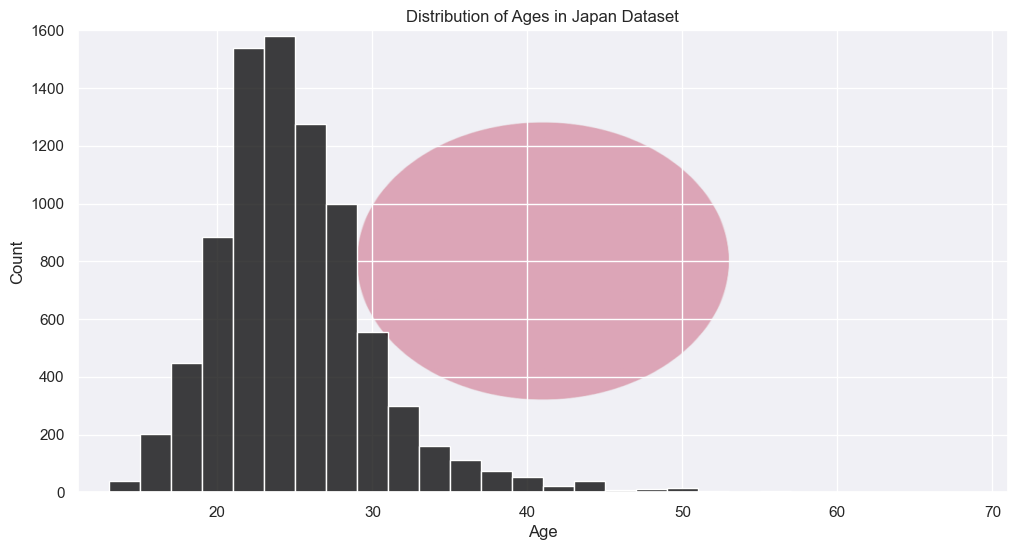

In [ ]:
athlete_ages = japan_data.groupby("Age")[["Sex", "Medal"]].count().reset_index()
athlete_ages = athlete_ages.rename(columns={"Sex": "Number_of_people", "Medal": "Number_of_medals"})

sns.set(style="darkgrid")

# Create a histogram plot
plt.figure(figsize=(12, 6))
sns.histplot(data=japan_data, x="Age", bins=30, kde=False, color="black")
plt.title('Distribution of Ages in Japan Dataset')
plt.xlabel('Age')
plt.ylabel('Count')


img = plt.imread("../Uppgifter/Filer/japan.png")
plt.imshow(img, extent=[min(japan_data['Age']), max(japan_data['Age']), 0, 1600], aspect='auto', alpha=0.3)

plt.show() 

In [ ]:
# Grupperar efter OS och räknar antalet medaljer
medals_per_year = japan_medals.groupby("Games")["Medal"].count().reset_index()

# Skapar en graf
fig = px.bar(medals_per_year, x="Games", y="Medal", color="Medal", title="Antal Olympiska Medaljer per OS för Japan")
fig.show()

print(medals_per_year)

          Games  Medal
0   1920 Summer      3
1   1924 Summer      1
2   1928 Summer      9
3   1932 Summer     31
4   1936 Summer     23
5   1952 Summer     12
6   1956 Summer     24
7   1956 Winter      1
8   1960 Summer     31
9   1964 Summer     62
10  1968 Summer     63
11  1972 Summer     56
12  1972 Winter      3
13  1976 Summer     41
14  1980 Winter      1
15  1984 Summer     49
16  1984 Winter      1
17  1988 Summer     20
18  1988 Winter      1
19  1992 Summer     47
20  1992 Winter     12
21  1994 Winter     10
22  1996 Summer     42
23  1998 Winter     13
24  2000 Summer     44
25  2002 Winter      2
26  2004 Summer     93
27  2006 Winter      1
28  2008 Summer     51
29  2010 Winter      7
30  2012 Summer     84
31  2014 Winter     11
32  2016 Summer     64
